In [265]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys 
from tqdm import tqdm_notebook as tqdm

import seaborn as sb
from seaborn import distplot

import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="All-NaN slice encounter") 
warnings.filterwarnings("ignore", message="Attempted to set non-positive bottom ylim on a log-scaled axis")

\textbf{How the sondes are classified :}

Terminology:  
'flag' : record of result of local test  
'good' : passes local test  
'bad'  : fails local test  
'ugly' : fails preliminary local test, but some data may be salvaged  

'FLAG' : record of result of group of tests or final flag for sonde  
'GOOD' : sonde is good, passed all tests and can be used straightaway  
'BAD'  : sonde is bad, should not be considered for any further data processing or analysis  
'UGLY' : sonde has some data that may be salvaged later, but cannot be processed straightaway. Needs more QC.


There are 3 individual processes used to classify sondes, which are combined later to make a final grouping:

1. \textbf{ind_FLAG:} Ratio of individual parameter's count to the total count of records (time is used as proxy for measurement record. Multiple parameters can have values at a single record.)
    - There is one flag each for the following parameters:  
    t : temperature (tdry)  
    p : pressure (pres)  
    rh: relative humidity (rh)  
    z : GPS altitude (gpsalt)  
    u : u wind (u_wind)  
    v : v wind (v_wind)  
    
    - For each parameter, if this proportional ratio is higher than the set threshold (based on overall distribution, explained later), then the sonde is flagged as 'good'. If the ratio is lower than set threshold, but non-zero, then the sonde is flagged 'ugly' and if the ratio is zero, i.e. this particular parameter was not measured at all for the sonde, then, it is flagged as 'bad'. (This value might later be changed from zero to 10% of the time counts).
    - If all individual ind_flags are 'good', the sonde is flagged as 'GOOD' for ind_FLAG,  
      if all individual ind_flags are 'bad', the sonde is flagged as 'BAD' for ind_FLAG,  
      if neither of these conditions is met, the sonde is flagged as 'UGLY' for ind_FLAG.
    

2. \textbf{srf_FLAG:} Values in the lower layer of the atmosphere (mostly near surface, but also < 4 km for some tests) as sanity checks
    - Functions are defined to check for obvious errors in near-surface values of parameters, such as being out of bounds (limits of realistic values), poor agreement between estimates of altitude, etc.
    - These functions are described in greater detail where the function is defined.
    - For each of these flags, if the sonde passes the test, it is marked as 1, else as 0, which stand for 'good' and 'bad' respectively. 
    - If all individual srf_flags are 'good', the sonde is flagged as 'GOOD' for srf_FLAG,  
      if all individual srf_flags are 'bad', the sonde is flagged as 'BAD' for srf_FLAG,  
      if neither of these conditions is met, the sonde is flagged as 'UGLY' for srf_FLAG.  
      
    
3. \textbf{ld_FLAG:} Checking whether the sonde detected a launch automatically. If the sonde fails to do this, it does not switch to high-power signal transmission, and thus, stops sending data back to the AVAPS PC, after a short range. 
    - The primary method to check launch detection is to parse through the log files of the sonde in raw format. These files have names starting with 'A' and are followed by the date and time of launch. The file extension is the number of the channel used to initialise the sonde and receive its signal, but for all practical purposes, it is a .txt file. (Note: For sondes that did not detect a launch, the file name has time when the sonde was initialised). The log file contains an internal record termed 'Launch Obs Done?'. If this value is 1, the launch was detected, else if it is 0, launch was not detected. The same values are used to mark the ld_FLAG.
    - An alternative method to check launch detection is through an attribute of the PQC files, called 'reference_time'. If a launch was detected, this attribute shows the launch time. If a launch was not detected automatically, the attribute shows the correct date, but the time is 'T00:00:00.000'. This can also be used to mark the ld_FLAG. However, this should only be used as a quick-fix if the log files are not available, since this test is not fool-proof. Moreover, PQC files with no automatic launch detection do not have relevant sonde information such as SondeID added to them. 
    
After the sondes pass through these three processes, the FLAGs are used to determine the final FLAG value for the sonde.  
    - If ld_FLAG is 0, then the sonde FLAG is termed 'BAD'  
    - If ld_FLAG is 1, and if both srf_FLAG and ind_FLAG are 'GOOD', then the sonde FLAG is termed 'GOOD'.  
    - If ld_FLAG is 1, and if both srf_FLAG and ind_FLAG are 'BAD', then the sonde FLAG is termed 'BAD'.  
    - If ld_FLAG is 1, and if srf_FLAG and ind_FLAG have different values, then the sonde FLAG is termed 'UGLY'.   
      
Although the process of classifying the sondes is simplified by summarising among the ind_flags and srf_flags, the method ensures that no good sondes are omitted, and no bad sondes are admitted. The rest of the sondes, the ugly sondes, still have data that can be salvaged, and after some QC and/or flagging, can be combined with the other good sondes.  
  
The NC file generated as a product stores results for each individual test, group of tests and the final classification. Thus, the user can still mould the classification based on their objectives or add/remove tests to the process and customise it for themselves.

In [368]:
def get_total_non_nan_indices(sonde) :
    
    """
    Retrieving the non-NaN indices for all parameters.
    
    'c' terms are complete arrays of indices that have non-NaN values
    's' terms are the counts of indices in the respective 'c' terms.
    
    
    Input : 
        sonde_path : Path to the sonde PQC file as a string
    Output :
        s_var : where, var is one of [time,t,rh,p,z,u,v]
        
    """
    
#     import xarray as xr
    import numpy as np
    
#     sonde = xr.open_dataset(sonde_path)
    
    c_time = ~np.isnan(sonde.time).values
    c_t    = ~np.isnan(sonde.tdry).values
    c_rh   = ~np.isnan(sonde.rh).values
    c_p    = ~np.isnan(sonde.pres).values
    c_z    = ~np.isnan(sonde.gpsalt).values
    c_u    = ~np.isnan(sonde.u_wind).values
    c_v    = ~np.isnan(sonde.v_wind).values
    
    s_time = c_time.sum()
    s_t    = c_t.sum()
    s_rh   = c_rh.sum()
    s_p    = c_p.sum()
    s_z    = c_z.sum()
    s_u    = c_u.sum()
    s_v    = c_v.sum()
    
    return s_time, s_t, s_rh, s_p, s_z, s_u, s_v


def pres_bounds(sonde,u_lim=1020,l_lim=1000) :
    
    '''
    Checking if maximum pressure of sonde is within bounds: 1000 hPa - 1020 hPa. 
    Value higher than bound is unrealistic, 
    and value lower than bound means sonde did not measure the bottommost levels of the atmosphere.
    
    This flag does not include any GPS values. Even if there were no pressure values above 1000 hPa, 
    there may still be GPS measurements in the lowest levels. 
    Such sondes can still be useful for wind and wind-derived products.
    
    Input : 
        sonde : Opened xarray dataset of ASPEN-processed PQC dropsonde file
    Output :
        bool : True, if max pressure value is within bounds
               False, if max pressure value is out of bounds
    '''

    
    if (sonde.pres.max() < 1000) | (sonde.pres.max() > 1020) :
        return False
    else :
        return True

def gps_bounds(sonde,limit=30) :
    
    """
    Checking if maximum GPS altitude of sonde is within bounds: <= limit (default assigned as 30 m)
    Value higher than bound has no near-surface measurements
    
    This flag does not include any pressure values. Even if there were no GPS values below 30 m,
    there may still be PTU measurements in the lowest levels. 
    
    Input : 
        sonde : Opened xarray dataset of ASPEN-processed PQC dropsonde file
    Output :
        bool : True, if min GPS altitude value is within bounds
               False, if min GPS altitude value is out of bounds
        
    """
    
    if sonde.gpsalt.min() > limit :
        return False
    else :
        return True
    
def tdry_bounds(sonde,u_limit=30,srf_limit=20) :
    """
    Checking if tdry (air temperature) is within bounds:
    
    1. Maximum air temperature recorded should not be greater than the upper limit (u_limit), 
        set to a default value of 30 deg C.
    2. Mean air temperature in the bottom 100 m (by gpsalt) should not be lesser than srf_limit, 
        set to a default of 20 deg C.
    
    If any of the above limits is violated, the tdry for the sonde is considered out of bounds,
    and marked as 'False'. The sonde is also marked 'False', if there are no measurements in the 
    bottom 100 m (by gpsalt). 
    
    Input : 
        sonde : Opened xarray dataset of ASPEN-processed PQC dropsonde file
    Output :
        bool : True, if tdry value is within bounds
               False, if tdry is out of bounds or if measurements are not available
    """
    if sonde.tdry.max() >= u_limit :
        return False
    elif sonde.tdry.where(sonde.gpsalt < 100,drop=True).sum() == 0 :
        return False
    elif sonde.tdry.where(sonde.gpsalt < 100,drop=True).mean() < srf_limit :
        return False
    else :
        return True
    
def rh_bounds(sonde,srf_limit=50) :
    """
    Checking if rh (relative humidity) is within bounds:
    
    1. Mean RH in the bottom 100 m (by gpsalt) should not be lesser than srf_limit, 
        set to a default of 50 %.
    
    If the above limit is violated, the rh for the sonde is considered out of bounds,
    and marked as 'False'. The sonde is also marked 'False', if there are no measurements in the 
    bottom 100 m (by gpsalt). 
    
    Input : 
        sonde : Opened xarray dataset of ASPEN-processed PQC dropsonde file
    Output :
        bool : True, if rh value is within bounds
               False, if rh is out of bounds or if measurements are not available
    """
    if sonde.rh.where(sonde.gpsalt < 100,drop=True).sum() == 0 :
        return False
    elif sonde.rh.where(sonde.gpsalt < 100,drop=True).mean() < srf_limit :
        return False
    else :
        return True

def palt_gpsalt_rms_check(sonde,rms_limit=100) :
    """
    This function estimates the root mean square (RMS) difference between geopotential altitude (palt) 
    and the GPS altitude (gpsalt),for values below 4 km, and based on a limit (rms_limit; 
    set to a default value of 100 m), is flagged accordingly.
    
    If the estimated RMS difference is below the limit, then the sonde is flagged as 'True' for this test.
    
    If the estimated RMS difference is greater than the limit, or if there are no values of either palt or gpsalt
    overlapping in the lower 4 km, then the sonde is flagged as 'False' for this test. The lack of overlap could be 
    because either there are no palt values or no gpsalt values or both.
    
    If the above limit is violated, the rh for the sonde is considered out of bounds,
    and marked as 'False'. The sonde is also marked 'False', if there are no measurements in the 
    bottom 100 m (by gpsalt). 
    
    Input : 
        sonde : Opened xarray dataset of ASPEN-processed PQC dropsonde file
    Output :
        bool : True, if RMS below limit
               False, if RMS above limit or no overlapping values
    """
    
    x = ((sonde.alt.where(sonde.alt < 4000,drop=True) 
          - sonde.gpsalt.where(sonde.alt < 4000,drop=True))**2).values
    
    nn = ~np.isnan(x)
    
    if nn.sum() == 0 :
        return False # all x are NaNs
    else :
        zdiff_rms = np.sqrt(np.nanmean(x))
        if zdiff_rms < rms_limit :
            return True
        else :
            return False
        
# Function to check if sonde failed due to no detection of launch

def check_launch_detect(sonde_path) :
    '''
    Alternative method to check automatic launch detection of the sonde
    
    Input : path to PQC file
    
    Output : If launch detected, True; else, False
    
    Function to check if the dropsonde detected no launch, and thus failed. This was a common
    cause of dropsonde failure during EUREC4A. Vaisala's best guess is that for some reason,
    the IR sensor near the parachute did not detect the parachute coming out, thus not 
    detecting a launch and thus, not switching from low-power transmission to high-power 
    transmission. This caused AVAPS to lose the sonde's signal very soon after 
    launch (~350 hPa).
    '''
    
    xrdataset = xr.open_dataset(sonde_path)
    
    if str(xrdataset.reference_time.values)[-21:-2] == 'T00:00:00.000000000' :
        launch_detect_flag = False # this means the sonde failed and launch was not detected
        print(xrdataset.attrs['SoundingDescription'][21:30],
              xrdataset.reference_time.values,
              xrdataset.launch_time.values)
    else :
        launch_detect_flag = True # this means launch was detected
    
    return launch_detect_flag 

def create_variable(ds, vname, data, **kwargs):
    """Insert the data into a variable in an :class:`xr.Dataset`"""
    attrs = nc_meta[vname].copy()
    dims = ['obs'] #nc_dims[vname]

    v = xr.Variable(
        dims, np.asarray(data), attrs=attrs)
    ds[vname] = v

    return vname 

In [293]:
###------ Platform Name ------###

Platform_Name = 'P3'

In [294]:
directory = 'Dropsondes/' + Platform_Name + '/All_dropsondes/'
# directory where all sonde files are present

a_dir = 'Dropsondes_raw/' + Platform_Name + '/All_A_files/'
# directory where all the A files are present

sonde_paths = sorted(glob.glob(directory+'*_PQC.nc')) 
# paths to the individual sonde files

file_time_str = [None] * len(sonde_paths) 
file_time = [None] * len(sonde_paths) 
# list to store extracted sonde time from file name as string and as time

a_files = [None] * len(sonde_paths) 
# list to store file names for the log files starting with A.

sonde_ds = [None] * len(sonde_paths) 
# list to store individual datasets of all sondes from PQC files

for i in range(len(sonde_paths)) :
    file_time_str[i] = sonde_paths[i][-22:-7]
    file_time[i] = np.datetime64(
                                pd.to_datetime(
                                            file_time_str[i], format='%Y%m%d_%H%M%S'),
                                's') 
    a_files[i] = 'A' + sonde_paths[i][-22:-7]
    sonde_ds[i] = xr.open_dataset(sonde_paths[i])

In [295]:
# Retrieving all non NaN index sums in to a list for all sondes
list_nc = list(map(get_total_non_nan_indices,sonde_ds))

In [296]:
s_time = [None] * len(list_nc)
s_t    = [None] * len(list_nc) 
s_rh   = [None] * len(list_nc) 
s_p    = [None] * len(list_nc)
s_z    = [None] * len(list_nc)
s_u    = [None] * len(list_nc)
s_v    = [None] * len(list_nc)
# creating lists to store non-NaN index sums for all parameters

list_of_variables = ['s_time', 's_t', 's_rh', 's_p', 's_z', 's_u', 's_v']
# list of parameter names as strings 

# sorting the non-NaN index sums from list_nc to the respective parameters' lists
for j,var in enumerate(list_of_variables) :
    for i in range(len(list_nc)) :
        eval(var)[i] = list_nc[i][j]

In [337]:
a_filepaths = []
# list to store individual file paths for all A files

for i in a_files :
    a_filepaths.append(sorted(glob.glob(a_dir+i+'*')))

ld_FLAG = np.full(len(a_files),np.nan)
# array to store ld_FLAG values

# create and start writing a log file which will store sonde info about sondes with failed launch detection
file = open('no_launch_detect_logs.txt','w') 

g = 0
# counter of failed sondes

for id_,i in enumerate(a_filepaths) :
     
    try :
        if len(i) == 0 :
            # if the file does not exist, i will be None, as no file would have been found and added to a_filepaths
            raise Exception 
        else :
            file_path = i[0]
            f = open(file_path,'r')
        
    except Exception :
        print(f'{a_files[id_]} : This file does not exist, at least not in the given directory')
        continue
        
    else :
        
        lines = f.readlines()
        
        # checking which line number in the file has the string we are looking for: "Launch Obs Done?"
        # this line number changes for different files
        for i,line in enumerate(lines) :
            if 'Launch Obs Done?' in line :
                line_id = i
                break
        
        # after line number is obtained, check if the value is an integer, or an exception
        try :
            if int(lines[line_id][25]) not in [0,1] :
                raise ValueError
            else :
                a = int(lines[line_id][25])
                
        except ValueError :
            print('An exception flew by : Value is neither 0 nor 1')
            continue
            
        else :
            if a == 0 : # if value is 0, then the launch detection failed
                ld_FLAG[id_] = False
                g += 1
                for line in lines :
                    if 'Sonde ID/Type/Rev' in line : 
                        # storing the sonde ID information and relevant details to the log file we created
                        file.write(line)
                    if 'START Time:' in line :
                        # storing the sonde start time to the log file we created
                        file.write(line)
                        # line breaker in our log file as a break between two file records
                        file.write('------------------------------------------\n')
                        break
            else :
                ld_FLAG[id_] = True 
                
file.write(f'In total, there were {g} sondes that didn\'t detect a launch.') 
# writing summary of failed sondes to the log file

file.close() 
# closing the log file 

A20200131_171854 : This file does not exist, at least not in the given directory
A20200203_144246 : This file does not exist, at least not in the given directory
A20200209_075032 : This file does not exist, at least not in the given directory
A20200210_044932 : This file does not exist, at least not in the given directory
A20200210_050114 : This file does not exist, at least not in the given directory
A20200210_062412 : This file does not exist, at least not in the given directory


In [339]:
# adding ld_FLAG to the list of variables, for easy addition to the dataset
if 'ld_FLAG' not in list_of_variables :
    list_of_variables.append('ld_FLAG')

data_vars = {}
# dictionary to store variables to be added to the dataset

# populating the dictionary with the variable names and respective data
for var in list_of_variables :
    data_vars[var] = (['time'],eval(var))

# Creating the dataset
status_ds = xr.Dataset(data_vars,
               coords = {'time' : file_time})

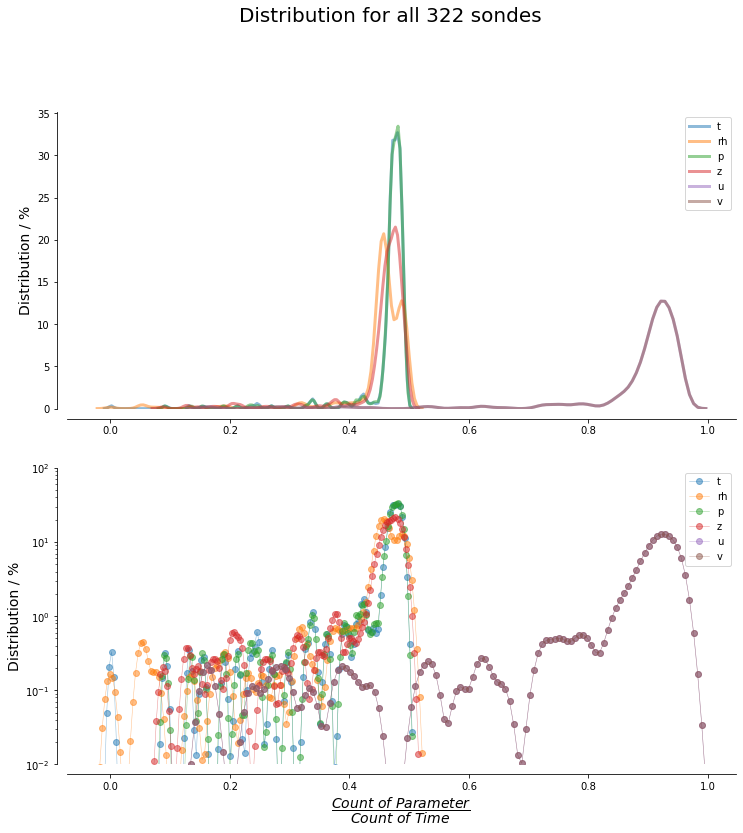

In [340]:
# Plotting the distribution of ratio of parameter's non-NaN measurement counts to counts of time

f,ax = plt.subplots(2,1,figsize=(12,12))

# looping over all parameters
for var in list_of_variables[1:-1] :
    
    # calculating ratio 
    rat = status_ds[var]/status_ds.s_time
    
    # plotting distribution on linear Y-axis
    sb.distplot(rat,hist=False,ax=ax[0],
                kde_kws={"linewidth": 3,#"marker":'o',
                            "alpha": 0.5},label=var[2:])
    
    # plotting distribution on log Y-axis
    sb.distplot(rat,hist=False,ax=ax[1],
                kde_kws={"linewidth": 0.5,"marker":'o',
                            "alpha": 0.5},label=var[2:])
    
    # setting the second plot's Y-axis to log scale
    ax[1].set_yscale('log') 
    plt.legend()
    ax[1].set_ylim(0.01,100)
    ax[1].set_xlabel(r'$\dfrac{Count\ of\ Parameter}{Count\ of\ Time}$',fontsize=14)
    [ax[m].set_ylabel('Distribution / %',fontsize=14) for m in [0,1]]
    [[ax[m].spines[n].set_visible(False) for m in [0,1]] for n in ['left','right','top']]
    plt.suptitle(f'Distribution for all {int(len(status_ds.time))} sondes',fontsize = 20,
                verticalalignment='bottom')
    
sb.despine(offset=10)

Time values are recorded every 0.25 seconds. Although, the PTU and GPS sensors have a measurement frequency of 2 Hz and 4 Hz, respectively, the distribution of measurements have a slightly different story. Based on the distribution, we know that the ideal case is for all parameters (except u,v) to have measurements at every other time record, and for u,v to have measurements at every time record. Since, the time records also include values during initialisation as well as during a little before and after the launch, when no signal can be sent back to the AVAPS PC, the actual ratio will always be lower than the ideal estimate of 1 (for u,v) and 0.5 (for the remaining parameters). 

The true distribution shows that peaks start to flatten around 0.8 and 0.4 for u,v and other parameters, respectively. Thus, sondes with ratios lower than these values are taken as not having a complete profile, and termed as 'ugly' sondes. These ugly sondes still have data, but because they are expected to have more NaN fields than most sondes, they are kept for more QC, NaN-filling later, depending upon the extent of the dearth of measurements in that sonde.

P.S. It is still unclear to me why GPS values are only at every other time record, while u,v are always being estimated.

In [341]:
# Determining ind_flags and adding to the dataset

rat = [None] * len(list_of_variables[1:-1])
rat_id = [None] * len(list_of_variables[1:-1])

# looping over all parameters except time
for i,var in enumerate(list_of_variables[1:-1]) :
    
    # estimating the ratio of the parameter counts to time counts
    rat[i] = status_ds[var].values/status_ds.s_time.values
    
    if var == 's_u' or var == 's_v' :
        thresh = 0.8
        
    else :
        thresh = 0.4
    
    # assigning flag values
    rat_id[i] = np.where(rat[i] > thresh, 'good', 'ugly')
    
    for j in range(len(rat[i])) :
        if rat[i][j] == 0 :
            rat_id[i][j] = 'bad'

ind_flag_vars = ['t_flag', 'rh_flag', 'p_flag', 'z_flag', 'u_flag', 'v_flag']
# list of all ind_flags

# adding the flags to the dataset
for i,j in zip(ind_flag_vars,rat_id) :
    status_ds[i] = (['time'],j)

In [342]:
# Determining srf_flags and adding to the dataset

srf_p_flag = np.full(len(sonde_paths),np.nan)
srf_z_flag = np.full(len(sonde_paths),np.nan)
srf_t_flag = np.full(len(sonde_paths),np.nan)
srf_rh_flag = np.full(len(sonde_paths),np.nan)
rms_palt_gpsalt = np.full(len(sonde_paths),np.nan)
# creating arrays to store the srf_flags

# looping over all sondes
for id_,i in enumerate(sonde_paths):
    
    # estimating all srf_flags
    sonde = xr.open_dataset(i)
    srf_p_flag[id_] = pres_bounds(sonde)
    srf_z_flag[id_] = gps_bounds(sonde)
    srf_t_flag[id_] = tdry_bounds(sonde)
    srf_rh_flag[id_] = rh_bounds(sonde)
    rms_palt_gpsalt[id_] = palt_gpsalt_rms_check(sonde)
    
srf_flag_vars = ['srf_p_flag', 'srf_z_flag', 'srf_t_flag', 'srf_rh_flag','rms_palt_gpsalt']
# list of all srf_flags

# adding the flags to the dataset
for var in srf_flag_vars :
    status_ds[var] = (['time'],eval(var))

In [343]:
# Determining ind_FLAG (refer notes at the top of document)

ind_FLAG = [None] * len(status_ds.time)

ind_all_good = np.where([all(
            item == 'good' for item in status_ds[ind_flag_vars].sel(time=i).to_array().values
            ) for i in status_ds.time])[0]

ind_all_bad = np.where([all(
            item == 'bad' for item in status_ds[ind_flag_vars].sel(time=i).to_array().values
            ) for i in status_ds.time])[0]

ind_any_ugly_or_bad = np.where([any(
            (item == 'ugly') or (item == 'bad') for item in status_ds[ind_flag_vars].sel(time=i).to_array().values
            ) for i in status_ds.time])[0]
    
for i in ind_all_good :
    ind_FLAG[i] = 'GOOD'
    
for i in ind_any_ugly_or_bad :
    ind_FLAG[i] = 'UGLY'

for i in ind_all_bad :
    ind_FLAG[i] = 'BAD'
    
status_ds['ind_FLAG'] = (['time'],ind_FLAG)

In [344]:
# Determining srf_FLAG (refer notes at the top of document)

srf_FLAG = [None] * len(status_ds.time)

srf_all_good = set(np.where([all(
                    item == 1 for item in status_ds[srf_flag_vars].sel(time=i).to_array().values
                    ) for i in status_ds.time])[0])

srf_all_bad = set(np.where([all(
                    item == 0 for item in status_ds[srf_flag_vars].sel(time=i).to_array().values
                    ) for i in status_ds.time])[0])

any_bad = set(np.where(([any(
                    item == 0 for item in status_ds[srf_flag_vars].sel(time=i).to_array().values
                    ) for i in status_ds.time]))[0])

srf_any_bad = any_bad - any_bad.intersection(srf_all_bad)

for i in srf_all_good :
    srf_FLAG[i] = 'GOOD'
    
for i in srf_any_bad :
    srf_FLAG[i] = 'UGLY'

for i in srf_all_bad :
    srf_FLAG[i] = 'BAD'
    
status_ds['srf_FLAG'] = (['time'],srf_FLAG)

In [354]:
# Determining sonde FLAG (refer notes at the top of document)

FLAG = [None] * len(status_ds.time)


no_launch = np.where(status_ds.ld_FLAG != 1)[0]

for i in range(len(FLAG)) :
    
    if i in no_launch :
        FLAG[i] = 'BAD'
    else :
        
        if srf_FLAG[i] == 'BAD' and ind_FLAG[i] == 'BAD' :
            FLAG[i] = 'BAD'
        elif srf_FLAG[i] == 'GOOD' and ind_FLAG[i] == 'GOOD' :
            FLAG[i] = 'GOOD'
        else :
            FLAG[i] = 'UGLY'

status_ds['FLAG'] = (['time'],FLAG)

In [355]:
good_ind = len(status_ds.where(status_ds.ind_FLAG == 'GOOD',drop=True).time)
ugly_ind = len(status_ds.where(status_ds.ind_FLAG == 'UGLY',drop=True).time)
bad_ind = len(status_ds.where(status_ds.ind_FLAG == 'BAD',drop=True).time)

print(f'As per the ind_FLAG tests,')
print(f'out of which {good_ind} are good sondes,')
print(f'{bad_ind} are bad sondes\nand {ugly_ind} are ugly sondes.')

As per the ind_FLAG tests,
out of which 288 are good sondes,
0 are bad sondes
and 34 are ugly sondes.


In [356]:
good_srf = len(status_ds.where(status_ds.srf_FLAG == 'GOOD',drop=True).time)
ugly_srf = len(status_ds.where(status_ds.srf_FLAG == 'UGLY',drop=True).time)
bad_srf = len(status_ds.where(status_ds.srf_FLAG == 'BAD',drop=True).time)

print(f'As per the srf_FLAG tests,')
print(f'out of which {good_srf} are good sondes,')
print(f'{bad_srf} are bad sondes\nand {ugly_srf} are ugly sondes.')

As per the srf_FLAG tests,
out of which 284 are good sondes,
8 are bad sondes
and 30 are ugly sondes.


In [357]:
good_sondes = len(status_ds.where(status_ds.FLAG == 'GOOD',drop=True).time)
ugly_sondes = len(status_ds.where(status_ds.FLAG == 'UGLY',drop=True).time)
bad_sondes = len(status_ds.where(status_ds.FLAG == 'BAD',drop=True).time)

print(f'There are a total of {len(status_ds.time)} sondes')
print(f'out of which {good_sondes} are good sondes,')
print(f'{bad_sondes} are bad sondes\nand {ugly_sondes} are ugly sondes that can be salvaged with some effort.')

There are a total of 322 sondes
out of which 262 are good sondes,
10 are bad sondes
and 50 are ugly sondes that can be salvaged with some effort.


In [369]:

nc_meta = {
#         'trajectory' : {'cf_role' : 'trajectory_id'},
        
        'time' : {'standard_name' : 'time',
                  'long_name' : 'Time of recorded measurement',
                  'units' : 'seconds since 1970-01-01 00:00:00 UTC',
                  'calendar' : 'gregorian',
                  'axis' : 'T'
                  },
    
        'height' : {'standard_name' : 'geopotential_height',
                    'long_name' : 'Geopotential Height obtained by integrating upwards the atmospheric thickness estimated using the hypsometric equation',
                    'units' : 'gpm',
                    'axis' : 'Z',
                    'positive' : 'up'
                   },
        
        'latitude' : {'standard_name' : 'latitude',
                      'long_name' : 'North Latitude',
                      'units' : 'degree',
#                       'valid_range' : [-90.  90.],
                      'axis' : 'X'
                     },
    
        'longitude' : {'standard_name' : 'longitude',
                      'long_name' : 'East Longitude',
                      'units' : 'degree',
#                       'valid_range' : [-180.  180.],
                      'axis' : 'Y'
                      },

        
        'pressure' : {'standard_name' : 'air_pressure',
                      'long_name' : 'Atmospheric Pressure',
                      'units' : 'hPa',
                      'coordinates' : 'time longitude latitude height'},
    
        'temperature' : {'standard_name' : 'air_temperature',
                         'long_name' : 'Dry Bulb Temperature',
                         'units' : 'degree_Celsius',
                         'coordinates' : 'time longitude latitude height'},
    
        'relative_humidity' : {'standard_name' : 'relative_humidity',
                               'long_name' : 'Relative Humidity',
                               'units' : '%',
                               'coordinates' : 'time longitude latitude height'},
        
        'wind_speed' : {'standard_name' : 'wind_speed',
                        'long_name' : 'Wind Speed',
                        'units' : 'm/s',
                        'coordinates' : 'time longitude latitude height'},
    
        'wind_direction' : {'standard_name' : 'wind_from_direction',
                            'long_name' : 'Wind Direction',
                            'units' : 'm/s',
                            'coordinates' : 'time longitude latitude height'},
    
        }

# nc_dims = {
#         'time' : ['time'],
#         'height' : ['time'],
#         'pressure' : ['time'],
#         'temperature' : ['time']
#     }

In [475]:
attr

'Geopotential Altitude (m)'

In [472]:
flight_attrs = [None] * len(a_filepaths)

list_of_flight_attrs = ['True Heading (deg)',
                        'True Air Speed (m/s)',
                        'Ground Track (deg)',
                        'Ground Speed (m/s)',
                        'Longitude (deg)',
                        'Latitude (deg)',
                        'MSL Altitude (m)',
                        'Geopotential Altitude (m)']

for id_,i in enumerate(tqdm(a_filepaths)) :
    
    if status_ds.FLAG[id_] == 'GOOD' :
        
        flight_attrs[id_] = {}
        
        file_path = i[0]
        f = open(file_path,'r')
        
        
        lines = f.readlines()
        
        # checking which line number in the file has the string we are looking for: "Launch Obs Done?"
        # this line number changes for different files
        for attr in list_of_flight_attrs :
            for j in range(len(lines)) :
                if attr in lines[j] :
                    line_id = j
                    break
                    
#             if attr == 'True Air Speed (m/s)' :
#                 attr = 'True Air Speed (m s)'
            flight_attrs[id_][attr] = float(lines[line_id].split('= ')[1])
            
        f.close()

/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [473]:
for i in tqdm(range(len(sonde_ds)-317)) :
    
    if status_ds.FLAG[i] == 'GOOD' :

        ht_indices = ~np.isnan(sonde_ds[i].alt)
        # retrieving non-NaN indices of geopotential height (sonde_ds[i].alt)
        # only time values at these indices will be used in Level-2 trajectory data;
        # this means that only alternate u,v values are included in the Level-2 data 
        # PTU has 2 Hz measurement frequency, while GPS has a 4 Hz measurement frequency

        ###----- Dimensions -----###

        obs = np.arange(1,ht_indices.sum()+1,1)
        # creating the observations dimension of the NC file

        ###----- Variables -----###

        height = sonde_ds[i].alt[ht_indices].values
        # Variable array: geopotential height 

        time = sonde_ds[i].time[ht_indices].astype('float').values / 1e9
        # Variable array: time

        wind_speed = sonde_ds[i].wspd[ht_indices].values
        # Variable array: wind speed

        wind_direction = sonde_ds[i].wdir[ht_indices].values
        # Variable array: wind direction

        temperature = sonde_ds[i].tdry[ht_indices].values
        # Variable array: temperature

        pressure = sonde_ds[i].pres[ht_indices].values
        # Variable array: pressure

        relative_humidity = sonde_ds[i].rh[ht_indices].values
        # Variable array: relative humidity

        latitude = sonde_ds[i].lat[ht_indices].values
        # Variable array: latitude

        longitude = sonde_ds[i].lon[ht_indices].values
        # Variable array: longitude

        ###----- Global Attributes -----###


        nc_global_attrs = {
            'Title' : 'Sounding data containing temperature, pressure, humidity,'\
                           ' latitude, longitude, wind direction, wind speed, and time',
            'Campaign' : 'EUREC4A-ATOMIC',
            'Platform' : Platform_Name, 
            'Instrument' : 'Vaisala RD41',
            'Launch_date' : str(pd.to_datetime(file_time[i]).date()),
            'Launch time (UTC)' : str(sonde_ds[i].launch_time.values),
            'Sonde Serial ID' : sonde_ds[i].SondeId,
            'ASPEN Version' : sonde_ds[i].AspenVersion,
            'Mission PI' : 'Mission PI',
            'Flight latitude at launch' : 'BAHAMAS_lat',
            'Flight longitude at launch' : 'BAHAMAS_lon',
            'Flight altitude at launch' : 'BAHAMAS_alt',
            'Conventions' : 'CF-1.7',
            'featureType' : 'trajectory'

        }    

        to_save_ds = xr.Dataset(
                 coords = {'obs' : obs}
                        )

        for var in nc_meta.keys() :
            v = var
            create_variable(to_save_ds,var,eval(var))

        file_name = 'EUREC4A_' + str(Platform_Name) + '_Dropsonde-RD41_' + file_time_str[i] +'.nc'
        save_directory = 'JOANNE/Level_2/'

        comp = dict(zlib=True,
                    complevel=4,
                    fletcher32=True,
                    _FillValue=np.finfo('float32').max)

        encoding = {var: comp for var in to_save_ds.data_vars}

        for key in nc_global_attrs.keys():
            to_save_ds.attrs[key] = nc_global_attrs[key]

        for key in flight_attrs[i]:
            to_save_ds.attrs[key] = flight_attrs[i][key]
            
        to_save_ds.to_netcdf(
            save_directory+file_name,
            mode='w', format='NETCDF4', encoding=encoding
        )
        
    else :
        
            if i == 0 :
                print(file_time_str[i] + ' : No file output because sonde is flagged as ' + str(status_ds.FLAG[i].values))
                date = pd.to_datetime(file_time[i]).date()
            elif pd.to_datetime(file_time[i]).date() > date :
                print('------------------------------------------------')
                print(file_time_str[i] + ' : No file output because sonde is flagged as ' + str(status_ds.FLAG[i].values))
                date = pd.to_datetime(file_time[i]).date()
            else :
                print(file_time_str[i] + ' : No file output because sonde is flagged as ' + str(status_ds.FLAG[i].values))
                date = pd.to_datetime(file_time[i]).date()


/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


20200115_151916 : No file output because sonde is flagged as UGLY
20200115_165659 : No file output because sonde is flagged as UGLY



In [474]:
to_save_ds

<xarray.Dataset>
Dimensions:            (obs: 1172)
Coordinates:
  * obs                (obs) int64 1 2 3 4 5 6 ... 1167 1168 1169 1170 1171 1172
Data variables:
    time               (obs) float64 1.579e+09 1.579e+09 ... 1.579e+09 1.579e+09
    height             (obs) float32 0.0 7.385765 ... 7322.822 7330.508
    latitude           (obs) float32 nan nan 14.030672 ... 14.039411 14.039556
    longitude          (obs) float32 nan nan -55.00053 ... -54.981426 -54.98125
    pressure           (obs) float32 1017.81006 1016.9573 ... 414.6084 414.1864
    temperature        (obs) float32 25.073887 25.044424 ... -15.365232
    relative_humidity  (obs) float32 77.22522 77.210106 77.18005 ... nan nan nan
    wind_speed         (obs) float32 nan 10.415226 nan 10.296208 ... nan nan nan
    wind_direction     (obs) float32 nan 71.25477 nan 70.83668 ... nan nan nan
Attributes:
    Title:                       Sounding data containing temperature, pressu...
    Campaign:                    EUREC4A-ATOMIC
    Platform:                    P3
    Instrument:                  Vaisala RD41
    Launch_date:                 2020-01-17
    Launch time (UTC):           2020-01-17T14:53:42.000000000
    Sonde Serial ID:             193020142
    ASPEN Version:               Aspen V3.4.3
    Mission PI:                  Mission PI
    Flight latitude at launch:   BAHAMAS_lat
    Flight longitude at launch:  BAHAMAS_lon
    Flight altitude at launch:   BAHAMAS_alt
    Conventions:                 CF-1.7
    featureType:                 trajectory
    True Heading (deg):          73.8464
    Ground Track (deg):          78.2038
    Longitude (deg):             -54.9837
    Latitude (deg):              14.0395
    MSL Altitude (m):            7447.4
    Geopotential Altitude (m):   7426.014462

In [469]:
flight_attrs[i][key]

6785.827061

In [366]:
to_save_ds['time'] = xr.Variable(
        ['time'],time)#,attrs=attrs)

In [367]:
to_save_ds

<xarray.Dataset>
Dimensions:            (time: 499)
Coordinates:
  * time               (time) float64 1.581e+09 1.581e+09 ... 1.581e+09
Data variables:
    height             (time) float32 0.0 7.428794 ... 2646.817 2652.4404
    latitude           (time) float32 nan nan 14.304415 ... 14.310366 14.310072
    longitude          (time) float32 nan nan ... -55.98273 -55.982624
    pressure           (time) float32 1016.98126 1016.1266 ... 744.82544
    temperature        (time) float32 25.882437 25.861782 ... 9.547535 9.551273
    relative_humidity  (time) float32 73.70929 73.81858 ... 49.469944 48.559475
    wind_speed         (time) float32 nan 10.419058 10.669661 ... nan nan nan
    wind_direction     (time) float32 nan 81.245926 82.23007 ... nan nan nan
    time_              (time) float64 1.581e+09 1.581e+09 ... 1.581e+09
Attributes:
    Title:              Sounding data containing temperature, pressure, humid...
    Campaign:           EUREC4A-ATOMIC
    Platform:           P3
    Instrument:         Vaisala RD41
    Launch_date:        2020-02-11
    Launch time (UTC):  2020-02-11T09:43:11.000000000
    Sonde Serial ID:    191640546
    ASPEN Version:      Aspen V3.4.3
    Mission PI:         Mission PI
    BAHAMAS_lat:        BAHAMAS_lat
    BAHAMAS_lon:        BAHAMAS_lon
    BAHAMAS_alt:        BAHAMAS_alt
    Conventions:        CF-1.7
    featureType:        trajectory